In [1]:
from affinewarp import PiecewiseWarping
from affinewarp.metrics import warp_distances
from scipy.ndimage import gaussian_filter1d
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_data(params, noise="gaussian"):
    """Generates data and ground truth model."""
    
    # Create ground-truth model.
    model = PiecewiseWarping(n_knots=params['n_knots'])
    
    # Initialize warping knots.
    model.initialize_warps(params['n_trials'])
    model.x_knots, model.y_knots = model._mutate_knots(params['knot_mutation'])
    if params['clip_knots']:
        model.y_knots[:, 0] = 0.
        model.y_knots[:, -1] = 1.
    
    # Initialize template.
    template_shape = params['n_timepoints'], params['n_neurons']
    template = params['template_base'] + params['template_amplitude'] * np.random.rand(*template_shape)
    template = gaussian_filter1d(template, params['template_sigma'], axis=0)
    model.template = template
    
    # Generate data
    data = model.predict()
    if params['noise'] == 'poisson':
        data = np.random.poisson(data)
    elif params['noise'] == 'gaussian':
        data += params['noise_amplitude'] * np.random.randn(*data.shape)
    
    return data, model

In [3]:
data_params = {
    'n_trials': 120,
    'n_timepoints': 100,
    'n_neurons': 50,
    'clip_knots': True,
    'template_amplitude': 20.0,
    'template_base': 3.0,
    'template_sigma': 2.0,
    'noise': 'poisson',
    'noise_amplitude': .1,
    'n_knots': 1,
    'knot_mutation': 0.1,
}
data, ground_truth = generate_data(data_params)

100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


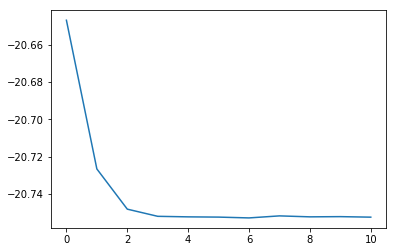

In [4]:
model = PiecewiseWarping(n_knots=1, l2_reg_scale=0.0, smoothness_reg_scale=0.0,
                         warp_reg_scale=0.0, n_restarts=1, loss='poisson')
model.fit(data, iterations=10)
plt.plot(model.loss_hist)

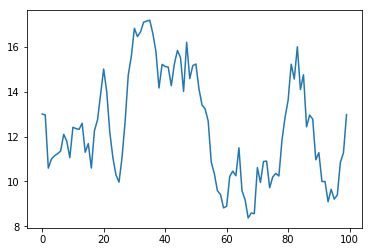

In [5]:
plt.plot(np.exp(model.template[:, 0]))

In [6]:
model = PiecewiseWarping(n_knots=1, l2_reg_scale=0.0, smoothness_reg_scale=100.0,
                         warp_reg_scale=0.0, n_restarts=1, loss='poisson')
model.fit(data, iterations=10)

/Users/alex/code/affinewarp/affinewarp/_optimizers.py:383: RuntimeWarning: overflow encountered in exp
  fr = np.exp(log_fr)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/Users/alex/code/affinewarp/affinewarp/_optimizers.py:396: RuntimeWarning: invalid value encountered in multiply
  self.grad += self.smoothness_scale * self.DtD.dot(fr) * fr / x.size
/Users/alex/code/affinewarp/affinewarp/_optimizers.py:399: RuntimeWarning: invalid value encountered in double_scalars
  obj += .5 * self.l2_scale * np.dot(fr.ravel(), fr.ravel()) / x.size
/Users/alex/code/affinewarp/affinewarp/_optimizers.py:400: RuntimeWarning: invalid value encountered in multiply
  self.grad += self.l2_scale * fr * fr / x.size
100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


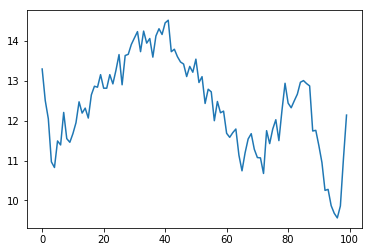

In [7]:
plt.plot(model.template[:, 0])

In [5]:
def rel_err(X, Xhat):
    return np.linalg.norm(X - Xhat) / np.linalg.norm(X)

In [6]:
def evaluate(model, ground_truth, n_replicates):
    warp_errors = []
    template_errors = []
    
    for i in range(n_replicates):
        # Fit model.
        model.fit(data, iterations=25, warp_iterations=40, verbose=False)

        # Evaluate warping error.
        warp_errors.append(warp_distances(model, ground_truth).mean())

        # Evaluate template error.
        template_errors.append(rel_err(data, model.predict()))
#         template_errors.append(rel_err(ground_truth.template, model.template))

    return warp_errors, template_errors, model.template

In [7]:
n_replicates = 5
max_knots = 4
warp_errors = np.empty((max_knots, n_replicates))
template_errors = np.empty((max_knots, n_replicates))
templates = np.empty([max_knots] + list(data.shape[1:]))

for n_knots in trange(max_knots):
    model = PiecewiseWarping(n_knots=n_knots, l2_reg_scale=0.0, max_temp=-1.,
                             smoothness_reg_scale=0.0, warp_reg_scale=0.0, n_restarts=1, loss='quadratic')
    warp_errors[n_knots], template_errors[n_knots], templates[n_knots] = evaluate(model, ground_truth, n_replicates)

100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


In [7]:
from affinewarp.visualization import binned_heatmap

NameError: name 'warp_errors' is not defined

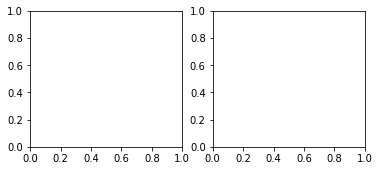

In [8]:
baseline = PiecewiseWarping(n_knots=data_params['n_knots'])
baseline.initialize_warps(data_params['n_trials'])
baseline.template = data.mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

axes[0].plot(warp_errors, '.k', ms=12, alpha=.65, mew=0)
axes[0].plot(warp_errors.mean(axis=1), '-r', alpha=.75, lw=2)
axes[0].axhline(warp_distances(ground_truth, baseline).mean(), color='k', dashes=[2,2])
axes[0].axhline(0, color='k', dashes=[2,2])
axes[0].set_xlabel('# of knots')
axes[0].set_ylabel('Error in warps')

axes[1].plot(template_errors, '.k', ms=12, alpha=.65, mew=0)
axes[1].plot(template_errors.mean(axis=1), '-r', alpha=.75, lw=2)
axes[1].axhline(rel_err(data, baseline.predict()), color='k', dashes=[2,2])
axes[1].axhline(rel_err(data, ground_truth.predict()), color='k', dashes=[2,2])
axes[1].set_xlabel('# of knots')
axes[1].set_ylabel('Reconstruction error')

fig.tight_layout()

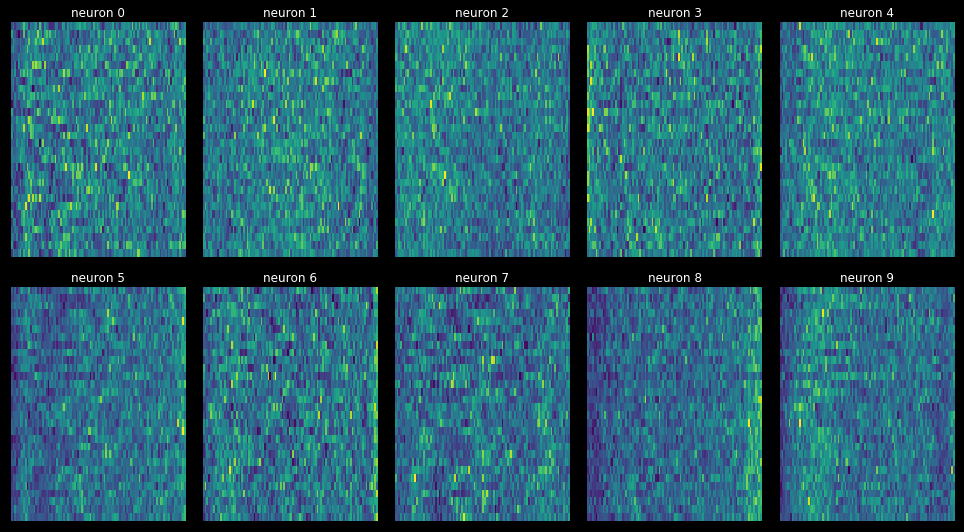

In [9]:
binned_heatmap(data[:30], subplots=(2,5));

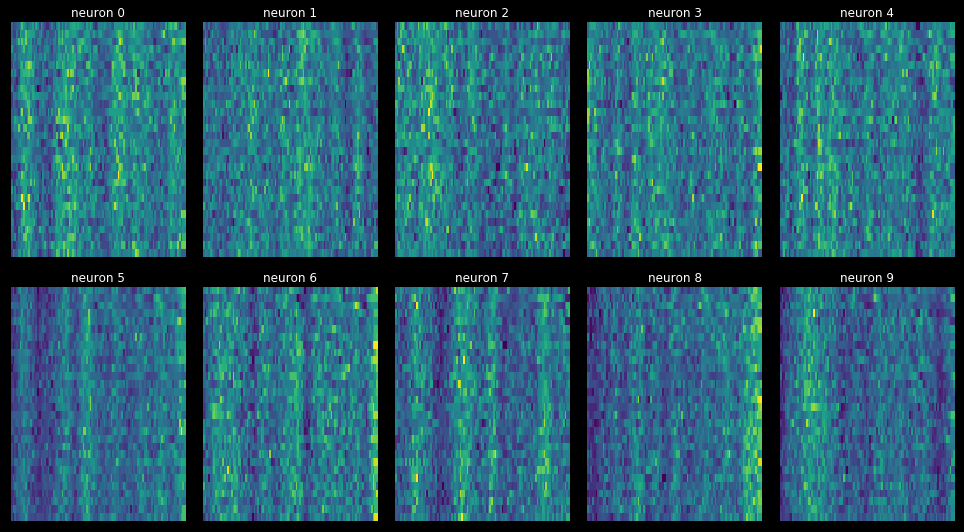

In [10]:
binned_heatmap(model.transform(data)[:30], subplots=(2,5));

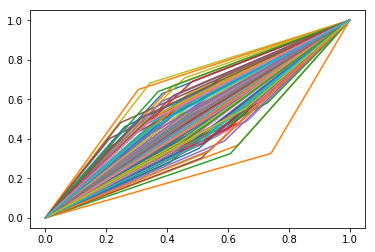

In [11]:
plt.plot(ground_truth.x_knots.T, ground_truth.y_knots.T);

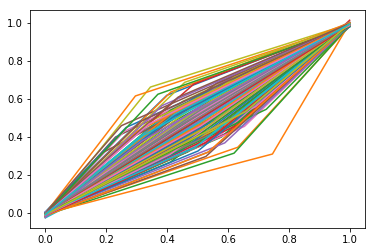

In [12]:
plt.plot(model.x_knots.T, model.y_knots.T);